# Sentiment Analysis of Tweets Dataset using the following Machine Learning models
- Logistic Regression
- Random Forest Classifier
- Extra Trees Classifier
- Ada Boost Classifier
- Naive Bayes

In [6]:
# import required libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import string

In [7]:
# download punctuation and stopwords from nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
import os
# Find the latest version of spark 3.2  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.2.3'
# spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


# Transform the data

In [9]:
# load tweets_df and view
# tweets_df = pd.read_csv("Resources/Tweets.csv")



from pyspark import SparkFiles
# url ="https://tweet-2022.s3.amazonaws.com/Tweets.csv"
# spark.sparkContext.addFile(url)
# spark_tweets_df = spark.read.csv(SparkFiles.get("Tweets.csv"), sep=",", header=True)
# tweets_df = spark.read.csv(SparkFiles.get("Tweets.csv"), sep=",", header=True)


tweets_df = pd.read_csv("/content/Tweets.csv")
# tweets_df=spark_tweets_df.toPandas()
tweets_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [10]:
# get dataframe ready for processing

# make sure the tweets in column "text" are strings
tweets_df['text'] = tweets_df['text'].astype('str')

# delete the unneccessary columns
tweets_df = tweets_df.drop(columns=["textID", "selected_text"])

In [11]:
def process_tweets(tweet):
    # make the text all lowercase
    tweet = tweet.lower()
    
    # remove punctuation
    tweet = "".join(char for char in tweet if char not in string.punctuation)
    
    # tokenize the tweet for url clean
    tokenize_tweet_url = word_tokenize(tweet)
    
    # remove urls
    tokenize_tweet_url = " ".join([i for i in tokenize_tweet_url if 'http' not in i])
    
    # tokenize the tweet
    tokenize_tweets = word_tokenize(tokenize_tweet_url)
    
    # remove stopwords
    stopword = stopwords.words("english")
    tweet_wo_stop = [word for word in tokenize_tweets if word not in stopword]
    
    # lemmatization
    lemm = WordNetLemmatizer()
    lemmed = [lemm.lemmatize(word) for word in tweet_wo_stop]
    
    # put string together
    final_tweet = " ".join(lemmed)
    
    return final_tweet

In [12]:
# process tweets using above function
tweets_df['text'] = tweets_df['text'].apply(lambda x: process_tweets(x))
tweets_df = tweets_df.dropna()

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,neutral
1,sooo sad miss san diego,negative
2,bos bullying,negative
3,interview leave alone,negative
4,son couldnt put release already bought,negative


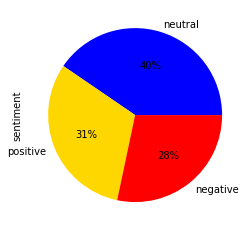

In [13]:
# visualize distribution
tweets_df.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'gold', 'red'])

In [14]:
# transform the sentiment column into numbers
dict_sentiment = {'positive': 1, 'neutral': 0, 'negative': -1}
tweets_df['sentiment'] = tweets_df['sentiment'].apply(lambda x: dict_sentiment.get(x))

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,0
1,sooo sad miss san diego,-1
2,bos bullying,-1
3,interview leave alone,-1
4,son couldnt put release already bought,-1


In [15]:
# create a separate data frame without neutral tweets
tweets_no_neut = tweets_df[tweets_df["sentiment"] != 0]

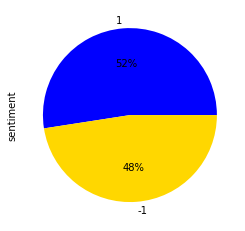

In [31]:
# visualize distribution - without neutral sentiment
tweets_no_neut.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'gold', 'red'])

In [16]:
# Create the X and y data 
def create_train_test_data (tweets_df, train_size):
    
    # assign X and y to the input and target columns
    X = tweets_df['text']
    y = tweets_df['sentiment']

    # split the data into testing data and training data
    if train_size == 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)

    # transform the data into tfidf vectors
    # fit the tfidf vectorizer on the training data to avoid bias
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, y_train, y_test

In [17]:
# create the model
def create_model(tweets_df, attempt_num, model, train_size):
    # Get the train and test data
    
    X_train_tfidf, X_test_tfidf, y_train, y_test = create_train_test_data (tweets_df, train_size)

    # create a logistic regression model and fit it to the training data
    
    model.fit(X_train_tfidf, y_train)
    evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num)

In [18]:
# evaluate the model
def evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num):
    
    # look at the scores for the testing and training data
    print(f"Attempt {attempt_num} ----------------------------------------")
    print(f"Training Data Score: {model.score(X_train_tfidf, y_train)}")
    print(f"Testing Data Score: {model.score(X_test_tfidf, y_test)} \n")

    # find metrics for testing data
    print(confusion_matrix(y_test.values, model.predict(X_test_tfidf)))
    print(classification_report(y_test.values, model.predict(X_test_tfidf)))

## Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
create_model(tweets_df, 1, model, 0)
create_model(tweets_no_neut, 2, model, 0)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Attempt 1 ----------------------------------------
Training Data Score: 0.8197476952935469
Testing Data Score: 0.6795226313491486 

[[1164  717  104]
 [ 384 2052  324]
 [  83  590 1453]]
              precision    recall  f1-score   support

          -1       0.71      0.59      0.64      1985
           0       0.61      0.74      0.67      2760
           1       0.77      0.68      0.73      2126

    accuracy                           0.68      6871
   macro avg       0.70      0.67      0.68      6871
weighted avg       0.69      0.68      0.68      6871

Attempt 2 ----------------------------------------
Training Data Score: 0.9323663624511083
Testing Data Score: 0.8645807870936202 

[[1701  259]
 [ 295 1836]]
              precision    recall  f1-score   support

          -1       0.85      0.87      0.86      1960
           1       0.88      0.86      0.87      2131

    accuracy                           0.86      4091
   macro avg       0.86      0.86      0.86      4091
w

## Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

twitter_classi = RandomForestClassifier(n_estimators=300, random_state=0)
create_model(tweets_df, 1, twitter_classi, train_size=.8)
create_model(tweets_no_neut, 2, twitter_classi, train_size=.8)

Attempt 1 ----------------------------------------
Training Data Score: 0.99745269286754
Testing Data Score: 0.6985628524649808 

[[ 917  514  140]
 [ 263 1650  314]
 [  63  363 1273]]
              precision    recall  f1-score   support

          -1       0.74      0.58      0.65      1571
           0       0.65      0.74      0.69      2227
           1       0.74      0.75      0.74      1699

    accuracy                           0.70      5497
   macro avg       0.71      0.69      0.70      5497
weighted avg       0.70      0.70      0.70      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.9996180290297937
Testing Data Score: 0.8505957836846929 

[[1332  196]
 [ 293 1452]]
              precision    recall  f1-score   support

          -1       0.82      0.87      0.84      1528
           1       0.88      0.83      0.86      1745

    accuracy                           0.85      3273
   macro avg       0.85      0.85      0.85      3273
wei

## Extra Trees Classifier

In [21]:
from sklearn.ensemble import ExtraTreesClassifier

twitter_ex = ExtraTreesClassifier(random_state=1)
create_model(tweets_df, 1, twitter_ex, train_size=.8)
create_model(tweets_no_neut, 2, twitter_ex, train_size=.8)

Attempt 1 ----------------------------------------
Training Data Score: 0.9977711062590975
Testing Data Score: 0.7000181917409496 

[[ 917  500  104]
 [ 292 1644  301]
 [  66  386 1287]]
              precision    recall  f1-score   support

          -1       0.72      0.60      0.66      1521
           0       0.65      0.73      0.69      2237
           1       0.76      0.74      0.75      1739

    accuracy                           0.70      5497
   macro avg       0.71      0.69      0.70      5497
weighted avg       0.70      0.70      0.70      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.9995416348357525
Testing Data Score: 0.8594561564314085 

[[1347  186]
 [ 274 1466]]
              precision    recall  f1-score   support

          -1       0.83      0.88      0.85      1533
           1       0.89      0.84      0.86      1740

    accuracy                           0.86      3273
   macro avg       0.86      0.86      0.86      3273
w

## Ada Boost Classifier

In [22]:
from sklearn.ensemble import AdaBoostClassifier
twitter_ada = AdaBoostClassifier(random_state=1)
create_model(tweets_df, 1, twitter_ada, train_size=.8)
create_model(tweets_no_neut, 2, twitter_ada, train_size=.8)

Attempt 1 ----------------------------------------
Training Data Score: 0.6571142649199417
Testing Data Score: 0.643441877387666 

[[ 618  870  119]
 [ 152 1795  269]
 [  44  506 1124]]
              precision    recall  f1-score   support

          -1       0.76      0.38      0.51      1607
           0       0.57      0.81      0.67      2216
           1       0.74      0.67      0.71      1674

    accuracy                           0.64      5497
   macro avg       0.69      0.62      0.63      5497
weighted avg       0.68      0.64      0.63      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.8076394194041253
Testing Data Score: 0.79040635502597 

[[1448  167]
 [ 519 1139]]
              precision    recall  f1-score   support

          -1       0.74      0.90      0.81      1615
           1       0.87      0.69      0.77      1658

    accuracy                           0.79      3273
   macro avg       0.80      0.79      0.79      3273
weig

# Naive Bayes

In [23]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
create_model(tweets_df,1,mnb,train_size=0.8)
create_model(tweets_no_neut,2,mnb,train_size=0.8)

Attempt 1 ----------------------------------------
Training Data Score: 0.7968977438136827
Testing Data Score: 0.6110605784973622 

[[ 632  893   58]
 [ 151 1794  275]
 [  40  721  933]]
              precision    recall  f1-score   support

          -1       0.77      0.40      0.53      1583
           0       0.53      0.81      0.64      2220
           1       0.74      0.55      0.63      1694

    accuracy                           0.61      5497
   macro avg       0.68      0.59      0.60      5497
weighted avg       0.66      0.61      0.60      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.9377387318563789
Testing Data Score: 0.8472349526428353 

[[1275  319]
 [ 181 1498]]
              precision    recall  f1-score   support

          -1       0.88      0.80      0.84      1594
           1       0.82      0.89      0.86      1679

    accuracy                           0.85      3273
   macro avg       0.85      0.85      0.85      3273
w

# Naive Bayes using PySpark

In [24]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NaiveBayes").getOrCreate()
# url ="https://tweet-2022.s3.amazonaws.com/Tweets.csv"
# spark.sparkContext.addFile(url)
# spark_tweets_df = spark.read.csv(SparkFiles.get("Tweets.csv"), sep=",", header=True)
# tweets_df = spark.read.csv(SparkFiles.get("Tweets.csv"), sep=",", header=True)


nb_tweets_df = pd.read_csv("/content/Tweets.csv")
# tweets_df=spark_tweets_df.toPandas()
nb_tweets_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [25]:
def nb_process_tweets(tweet):
    # make the text all lowercase
    tweet = tweet.lower()
    
    # remove punctuation
    tweet = "".join(char for char in tweet if char not in string.punctuation)
  
    # remove urls
    tweet_wo_stop = "".join([i for i in tweet if 'http' not in i])
    
    
    # lemmatization
    lemm = WordNetLemmatizer()
    lemmed = [lemm.lemmatize(word) for word in tweet_wo_stop]
    
    # put string together
    final_tweet = "".join(lemmed)
    
    return final_tweet
nb_tweets_df['text'] = nb_tweets_df['text'].astype('str')

# delete the unneccessary columns
nb_tweets_df = nb_tweets_df.drop(columns=["textID", "selected_text"])
nb_tweets_df=nb_tweets_df.rename(columns={'sentiment':'class'})
nb_tweets_df=nb_tweets_df[['class','text']]
nb_tweets_df['text'] = nb_tweets_df['text'].apply(lambda x: nb_process_tweets(x))


nb_opt=nb_tweets_df.loc[nb_tweets_df['class']!="neutral"]

In [26]:
pip install quinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline
from pyspark.sql import SQLContext
import quinn
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def create_nb(tweets_df,attempt_num,model,train_size):
    
    # Create all the features to the data set
    pos_neg_to_num = StringIndexer(inputCol='class',outputCol='label')
    tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
    stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
    hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token')
    idf = IDF(inputCol='hash_token', outputCol='idf_token')
    
    # Create feature vectors
    clean_up = VectorAssembler(inputCols=['idf_token', 'length'], outputCol='features')
    data_prep_pipeline = Pipeline(stages=[pos_neg_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])
    sc = SparkSession.builder.getOrCreate()
    sqlContext = SQLContext(sc)
    spark_tweets = sqlContext.createDataFrame(tweets_df)


    trimmed=spark_tweets.withColumn('description',quinn.single_space(spark_tweets['text']))
    trimmed=trimmed.select('class','description')
    trimmed=trimmed.withColumnRenamed('description','text')
    trimmed=trimmed.toPandas()
    trimmed['length']=""
    for index,row in trimmed.iterrows():
      nb_tweet_length=len(row['text'])
      trimmed.loc[index,'length']=nb_tweet_length
    trimmed_spark=sqlContext.createDataFrame(trimmed)
    cleaner = data_prep_pipeline.fit(trimmed_spark)
    cleaned = cleaner.transform(trimmed_spark)

    # cleaner = data_prep_pipeline.fit(spark_tweets)
    # cleaned = cleaner.transform(spark_tweets)
    
    # Break data down into a training set and a testing set
    # training, testing = cleaned.randomSplit([0.7, 0.3])
    training, testing = cleaned.randomSplit([train_size, 1-train_size])
    predictor = nb.fit(training)
    
    test_results = predictor.transform(testing)
    acc_eval = MulticlassClassificationEvaluator(labelCol="label")
    acc = acc_eval.evaluate(test_results)
    predictionAndTarget = test_results.select("label", "prediction")

  # Get metrics

    f1 = acc_eval.evaluate(predictionAndTarget, {acc_eval.metricName: "f1"})
    weightedPrecision = acc_eval.evaluate(predictionAndTarget, {acc_eval.metricName: "weightedPrecision"})
    weightedRecall = acc_eval.evaluate(predictionAndTarget, {acc_eval.metricName: "weightedRecall"})
    auc = acc_eval.evaluate(predictionAndTarget)
    print(f"Testing Accuracy of model:  {acc}")
    print(f"Precision of model:  {weightedPrecision}")
    print(f"Recall of model: {weightedRecall}")

In [30]:
nb = NaiveBayes(labelCol="label", featuresCol="features", modelType="multinomial")
create_nb(nb_tweets_df,1,nb,.8)
create_nb(nb_opt,2,nb,.8)


/content/spark-3.2.3-bin-hadoop2.7/python/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy of model at predicting sentiments was: 0.571905
Accuracy of model at predicting sentiments was: 0.797238
